## Vertical Profile Tutorial
This is an educational toolkit to demonstrate how to plot the CESM1 data as a vertical profile.
Vertical profiles are a vertical trend chart that display a parameter measured at a specified depth, location, and time frame. In this notebook, we will be covering how to create vertical profiles plot for the historic, present day and future projected data.

### Background information

##### Overview of Xarray and APIs
`Xarray` is a powerful Python library for handling multi-dimensional arrays, often used in atmospheric, oceanographic, and climate sciences. It provides a high-level API for managing labeled data, making it easy to perform complex operations on large datasets.

`APIs` (Application Programming Interfaces) allow different software applications to communicate with each other. In the context of data science, APIs provide access to various datasets and services over the internet, enabling seamless data retrieval and manipulation.

This tutorial will guide you through using Xarray and other libraries to analyze climate data from the CESM1 Large Ensemble dataset.

### CESM1 Large Ensemble
This portion of the notebook will detail how to get access to the CESM1 large Ensemble dataset, which is hosted on Amazon Web Services. Since it is hosted on Amazon Web services, the users accessing this data will not have to create a separate account. Directions will be followed very similarly to a NCAR repository labeled CESM LENS on AWS.
This has been modified to also include functionality to load a zarr-format grid file containing the latitude and longitude information for CESM1, which for some reason are not included in the data files.
Things to note about the data we are accessing:
The notebook will be accessing the Ocean model for CESM1
Because of this the grid file used here is only for OCEAN variables; the atmosphere and land variables have different lat and lon information.
For most ocean variables, latitude and longitude are called "TLAT" and "TLONG".
This notebook will only be looking at a few variables as an example. If you are inclined to view other variables, a whole list can be found here
To first open connection to where the files are housed, we need to open the connection by using the intake function

### Data Access
This notebook uses information from a notebook from the NCAR organization that can be found [here](https://ncar.github.io/CESM-Tutorial/notebooks/diagnostics/clm_ctsm/basics_clm.html#first-calculate-the-land-weights)


Accessing the data for this notebook will be done by using Pangeo's software to promote open access and reproducibility within this notebook. To properly ensure you have the correct packages installed that the 'Pangeo Environment' uses, make sure to view the .README for this repository found [here](https://github.com/Channelislanders/toolkit)
Here we are:
Accessing the OCN model dataset with RCP 8.5 and 20C runs.
Explain what these are
Narrowing down the columns to specific variables we aim to access.

DO,
salinity,
Temperature

For example:
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="TEMP",
    experiment=["20C", "RCP85"],  
)

Loading in lat/lon data separately which was not in CESM1 as of March 2024.
This section works similar to accessing other catalogs, we will be using Zarr. More information on the library below.
https://zarr.readthedocs.io/en/stable/


### Importing Packages
In order to access the data, we'll need to import all necessary packages to do so. Below are the packages I have installed to use throughout this notebook:

In [2]:
# Packages needed generally
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature
import xarray as xr
import pandas as pd
import numpy as np
from rasterio import mask

# Packages needed for CESM1 example
import pprint
import intake
import requests
import aiohttp
import s3fs

In [3]:
# Open original collection description file: CESM1 LENS
cat_url = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
col = intake.open_esm_datastore(cat_url)
col

In [4]:
# Search for the sea surface variable, display the first few entries in the resulting data frame
col.search(variable="TEMP").df

# the experiments and variables we want to work with at a monthly frequency
col.search(experiment = ["RCP85", "20C"], frequency = "monthly", variable = ["O2","SALT","TEMP","SST"]).df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,O2,dissolved oxygen,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-O2....
1,SALT,salinity,ocn,20C,monthly,60.0,global_ocean,gram/kilogram,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-SAL...
2,SST,potential temperature,ocn,20C,monthly,1.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-SST...
3,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
4,O2,dissolved oxygen,ocn,RCP85,monthly,60.0,global_ocean,mmol/m^3,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-O...
5,SALT,salinity,ocn,RCP85,monthly,60.0,global_ocean,gram/kilogram,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-S...
6,SST,potential temperature,ocn,RCP85,monthly,1.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-S...
7,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


In [5]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 scenarios
variables = ["TEMP", "SALT", "O2"]
col_ocn = {}

for var in variables:
    col_ocn[f"{var}"] = col.search(
        frequency=["monthly"],
        component="ocn",
        variable=var,
        experiment=["20C", "RCP85"],
    )

print(col_ocn)

#Display the first few entries in the resulting data frame
col_ocn["TEMP"].df
col_ocn["SALT"].df
col_ocn["O2"].df

{'TEMP': <aws-cesm1-le catalog with 2 dataset(s) from 2 asset(s)>, 'SALT': <aws-cesm1-le catalog with 2 dataset(s) from 2 asset(s)>, 'O2': <aws-cesm1-le catalog with 2 dataset(s) from 2 asset(s)>}


,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,O2,dissolved oxygen,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-O2....
1,O2,dissolved oxygen,ocn,RCP85,monthly,60.0,global_ocean,mmol/m^3,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-O...


In [6]:
# Load catalog entries for subset into a dictionary of xarray datasets
#Lets create another for loop to iteratre over the col_ocn dictionary

dsets = {}
for var in variables:
    dsets[var] = col_ocn[var].to_dataset_dict(
        zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
    )
    print(f"\nDataset dictionary keys for {var}:\n {dsets[var].keys()}")



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


/Users/olholt/.conda/envs/channelislanders/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/Users/olholt/.conda/envs/channelislanders/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)



Dataset dictionary keys for TEMP:
 dict_keys(['ocn.RCP85.monthly', 'ocn.20C.monthly'])

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys for SALT:
 dict_keys(['ocn.RCP85.monthly', 'ocn.20C.monthly'])

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys for O2:
 dict_keys(['ocn.RCP85.monthly', 'ocn.20C.monthly'])


In [7]:
# Define Xarray datasets corresponding to the two experiments by each variable 
ds_20C_TEMP = dsets["TEMP"]["ocn.20C.monthly"]
ds_RCP85_TEMP = dsets["TEMP"]["ocn.RCP85.monthly"]

ds_20C_SALT = dsets["SALT"]["ocn.20C.monthly"]
ds_RCP85_SALT = dsets["SALT"]["ocn.RCP85.monthly"]

ds_20C_O2 = dsets["O2"]["ocn.20C.monthly"]
ds_RCP85_O2 = dsets["O2"]["ocn.RCP85.monthly"]

### Downloading the .nc files
Downloading the subset data will help the plots run faster. A tip is to restart the kernel after each code chunk below to download each dataset. Once the file is downloaded, comment the code out when re-running the script.

In [8]:
#For Temperature in the 20C run
#latlon_subset = ds_20C_TEMP.isel(nlat = 280, nlon = 240)

#latlon_subset.to_netcdf("latlon_TEMP_subset.nc")

In [9]:
# Temperature in the RCP8.5 run
#latlon_subset_TEMP_rcp = ds_RCP85_TEMP.isel(nlat = 280, nlon = 240)

#latlon_subset_TEMP_rcp.to_netcdf("latlon_TEMP_subset_rcp.nc")

### Plotting Temperature for 20C run (1920-2005)

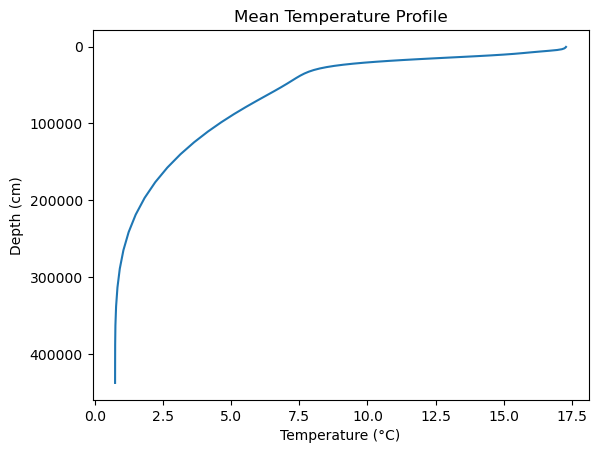

In [10]:
#load in the netcdf file created above
latlon_TEMP_final = xr.open_dataset("data/VP/latlon_TEMP_subset.nc")

# Initialize an empty list to store mean values for each member_id
TEMP_means_list = []

# Loop through each member_id and calculate the mean
for member in ds_20C_TEMP.member_id:
    member_mean = latlon_TEMP_final.sel(member_id=member).TEMP.mean("time")
    TEMP_means_list.append(member_mean)

# Convert the list to an xarray DataArray (assuming member IDs are a coordinate)
TEMP_means = xr.concat(TEMP_means_list, dim='member_id').mean('member_id')

# Plot the dissolved oxygen with inverted y-axis
plt.figure()
TEMP_means.plot(y='z_t')
plt.gca().invert_yaxis()
plt.xlabel('Temperature (°C)')
plt.ylabel('Depth (cm)')
plt.title('Mean Temperature Profile')
plt.show()

### Plotting Tempertaure for RCP8.5 run (2006-2100)

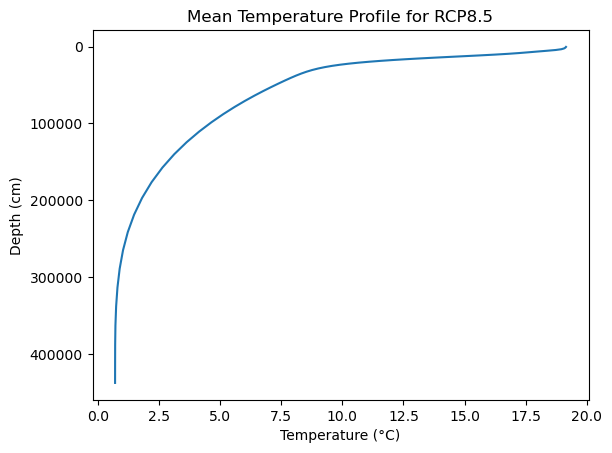

In [11]:
# Load in the netcdf file created above
latlon_TEMP_final_rcp = xr.open_dataset("data/VP/latlon_TEMP_subset_rcp.nc")

# Initialize an empty list to store mean values for each member_id
TEMP_means_list_rcp = []

# Loop through each member_id and calculate the mean
for member in latlon_TEMP_final_rcp.member_id:
    member_mean_rcp = latlon_TEMP_final_rcp.sel(member_id=member).TEMP.mean("time")
    TEMP_means_list_rcp.append(member_mean_rcp)

# Convert the list to an xarray DataArray (assuming member IDs are a coordinate)
TEMP_means_rcp = xr.concat(TEMP_means_list_rcp, dim='member_id').mean('member_id')

# Plot the data without inverting y-axis
plt.figure()
TEMP_means_rcp.plot(y='z_t')
plt.gca().invert_yaxis()
plt.xlabel('Temperature (°C)')
plt.ylabel('Depth (cm)')
plt.title('Mean Temperature Profile for RCP8.5')
plt.show()
